In [25]:
import logging
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np


# Configure logging
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(), logging.FileHandler('package_id')])

def load_data_OpenDataTO(package_id):
    """
    Load a dataset from the Toronto Open Data API.

    Parameters:
    - package_id (str): The ID of the package containing the dataset in a dict {}.

    Returns:
    - pd.DataFrame or None: A DataFrame containing the dataset if successfully loaded, 
                            or None if an error occurred.
    """
    # Define the base URL for the Toronto Open Data API
    base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

    # Define the URL to access the metadata of a package
    metadata_url = base_url + "/api/3/action/package_show"

    # Set the parameters to retrieve information about the desired package
    params = {"id": package_id}
         
    # Send a GET request to retrieve metadata about the package
    response = requests.get(metadata_url, params=params)

    # Check if the GET request was successful
    if response.status_code == 200:
        # Parse the JSON response
        package_info = response.json()
        
        # Extract information about the resources in the package
        resources = package_info['result']['resources']
        
        # Look for a JSON resource and load its data using CKAN API
        for resource in resources:
            if resource['format'].lower() == 'json':
                data_url = base_url + "/api/3/action/datastore_search"
                params = {"id": resource["id"]}
                filters = {
                    "ARREST_YEAR": [2018, 2019, 2020, 2021, 2022],
                    "DIVISION": "D11"  # Filter for DIVISION
                }

                all_records = []
                limit = 1000  # Number of records to retrieve per request
                
                # Paginate through the data until all records are retrieved
                offset = 0
                while True:
                    params["offset"] = offset
                    params["limit"] = limit
                    params["filters"] = json.dumps(filters)  # Encode filters as JSON string
                    response = requests.get(data_url, params=params)
                    response_json = response.json()
                    if "result" not in response_json or not response_json["success"]:
                        logging.error("Error retrieving data from the API.")
                        return None
                    
                    resource_search_data = response_json["result"]
                    records = resource_search_data.get("records", [])
                    all_records.extend(records)
                    
                    # Check if we have fetched all records
                    if len(records) < limit:
                        break  # Break the loop if all records have been retrieved
                    
                    offset += limit  # Move to the next page
                
                df = pd.DataFrame(all_records)
                logging.info("Toronto Open DataFrame created successfully using CKAN API parameters.")
                return df
        else:
            logging.warning("No JSON resource found in the package.")
            return None
            
    else:
        logging.error("Failed to retrieve metadata from the API.")
        return None

# Load the Annual Police Report data into the DataFrame
    
package_id = "police-annual-statistical-report-arrested-and-charged-persons"

annual_police_report = load_data_OpenDataTO(package_id)
if annual_police_report is not None:
    annual_police_report.head()
else:
    logging.error("Failed to load the dataset.")
annual_police_report.head()

INFO:root:Toronto Open DataFrame created successfully using CKAN API parameters.


,_id,ARREST_YEAR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,SEX,AGE_COHORT,AGE_GROUP,CATEGORY,SUBTYPE,ARREST_COUNT
0,17,2021,D11,111,Rockcliffe-Smythe (111),Male,35 to 44,Adult,Crimes Against the Person,Assaults,2
1,75,2020,D11,171,Junction-Wallace Emerson (171),Female,25 to 34,Adult,Crimes Against the Person,Assaults,3
2,129,2019,D11,171,Junction-Wallace Emerson (171),Male,18 to 24,Adult,Crimes Against the Person,Other,3
3,145,2022,D11,91,Weston-Pelham Park (91),Male,25 to 34,Adult,Other Criminal Code Violations,Other,8
4,150,2021,D11,88,High Park North (88),Male,18 to 24,Adult,Crimes Against the Person,Assaults,1


In [26]:
#converting column names to lowecase
def rename_data(annual_police_report):
  if annual_police_report is None:
    raise ValueError('No columns found')
  report=annual_police_report.rename(columns=str.lower)
  return report
rename_data(annual_police_report)
annual_police_report=rename_data(annual_police_report)
annual_police_report.head()

,_id,arrest_year,division,hood_158,neighbourhood_158,sex,age_cohort,age_group,category,subtype,arrest_count
0,17,2021,D11,111,Rockcliffe-Smythe (111),Male,35 to 44,Adult,Crimes Against the Person,Assaults,2
1,75,2020,D11,171,Junction-Wallace Emerson (171),Female,25 to 34,Adult,Crimes Against the Person,Assaults,3
2,129,2019,D11,171,Junction-Wallace Emerson (171),Male,18 to 24,Adult,Crimes Against the Person,Other,3
3,145,2022,D11,91,Weston-Pelham Park (91),Male,25 to 34,Adult,Other Criminal Code Violations,Other,8
4,150,2021,D11,88,High Park North (88),Male,18 to 24,Adult,Crimes Against the Person,Assaults,1


In [27]:
annual_police_report.shape

(3898, 11)

In [28]:
def total_only_f(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # Create a dataframe where 'category' is Total Arrests only 
    total_data = dataframe[dataframe['category'] == 'Total Arrests']

    return total_data

In [29]:
def by_year_f(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Group rows by year
    by_group = dataframe.groupby(['arrest_year'])

    # Add up all Total Arrests for each year
    year_sum = by_group.agg(arrest_count = ('arrest_count', 'sum'))

    return year_sum

In [30]:
total_df = total_only_f(annual_police_report)
by_year = by_year_f(total_df)
by_year

,arrest_count
arrest_year,
2018,1216
2019,1242
2020,1000
2021,943
2022,1127


In [31]:
def plotby_year_f(data: pd.DataFrame,column):
    fig,ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)   

    offset=0.7
    count = ax.bar(data.index, data[column], width=offset)

    ax.set_title('Arrests Count by Year, Toronto')
    ax.set_xlabel('Year')
    ax.set_ylabel('Counts')

    ax.legend()

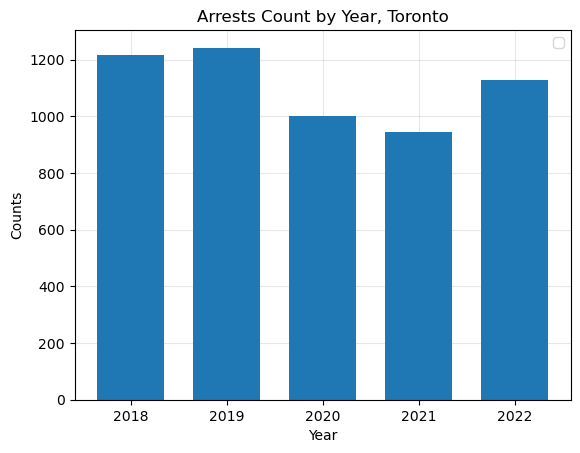

In [32]:
plotby_year_f(by_year,'arrest_count')

plt.savefig('arrest_by_year.pdf')
# write save command

In [33]:
def conditions_f(row):    
    if row["age_group"] == 'Adult':
        row['_adult'] = row['arrest_count']
        row['_youth'] = 0
    elif row["age_group"] == 'Youth':
        row['_adult'] = 0
        row['_youth'] = row['arrest_count']
    return row[['_adult','_youth']]

In [34]:
def by_year_age_f(data: pd.DataFrame) -> pd.DataFrame:

    # Group rows by year
    year_age_group = data.groupby(['arrest_year','age_group'])

    # Add up all Total Arrests for each year
    year_age_sum = year_age_group.agg(arrest_count = ('arrest_count', 'sum')).reset_index()

    # dropping unknown age_group
    year_age_sum = year_age_sum.drop(year_age_sum[year_age_sum['age_group'] == 'Unknown'].index)  

    # create columns '_adult', '_youth' based on 'age_group
    year_age_sum[['_adult','_youth']] = year_age_sum.apply(conditions_f, axis=1)

    # drop 'age_group' and 'arrest_count' because these values have been moved to '_adult','_youth'
    year_age_sum = year_age_sum.drop(['age_group', 'arrest_count'], axis=1)

    # group by year 
    year_age_group = year_age_sum.groupby(['arrest_year']).agg(adult=('_adult','sum'),
                                       youth=('_youth','sum')).reset_index()

    return year_age_group

In [35]:
def plotby_year_age_f(data):
    barWidth = 0.35

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(data['arrest_year']))
    r2 = [x + barWidth for x in r1]

    # Create the bar plots
    plt.bar(r1, data['adult'], color='#7f6d5f', width=barWidth, edgecolor='white', label='Adult')
    plt.bar(r2, data['youth'], color='#557f2d', width=barWidth, edgecolor='white', label='Youth')

    # Add x-axis and y-axis labels and a title
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.title('Arrest Counts by Year & Age group, Toronto')

    # Add legend
    plt.legend()

    #plt.show()

In [36]:
year_age_df = by_year_age_f(total_df)

In [37]:
year_age_df

,arrest_year,adult,youth
0,2018,1129,87
1,2019,1165,77
2,2020,947,53
3,2021,914,29
4,2022,1093,34


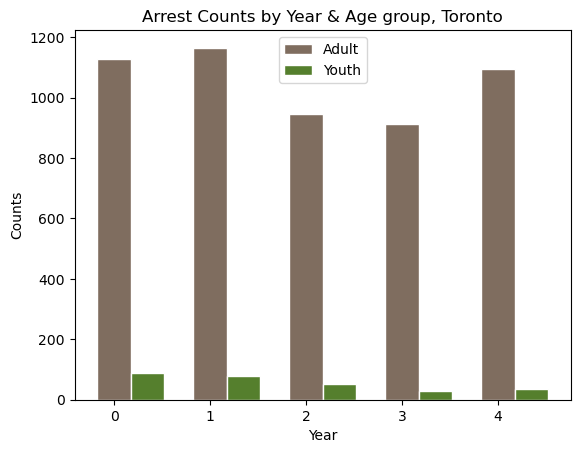

In [38]:
plotby_year_age_f(year_age_df)
plt.savefig('arrest_by_year_age.pdf')
# write save command